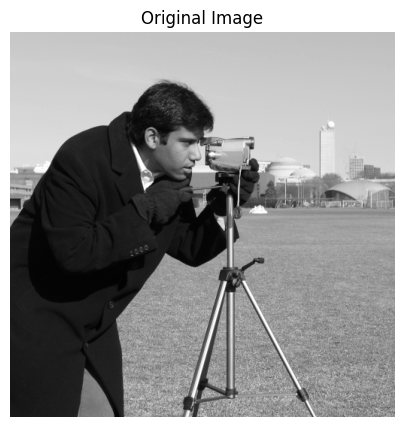

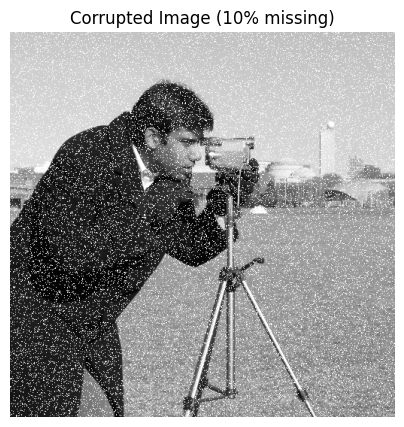

c:\Users\ROSE PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.60281e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


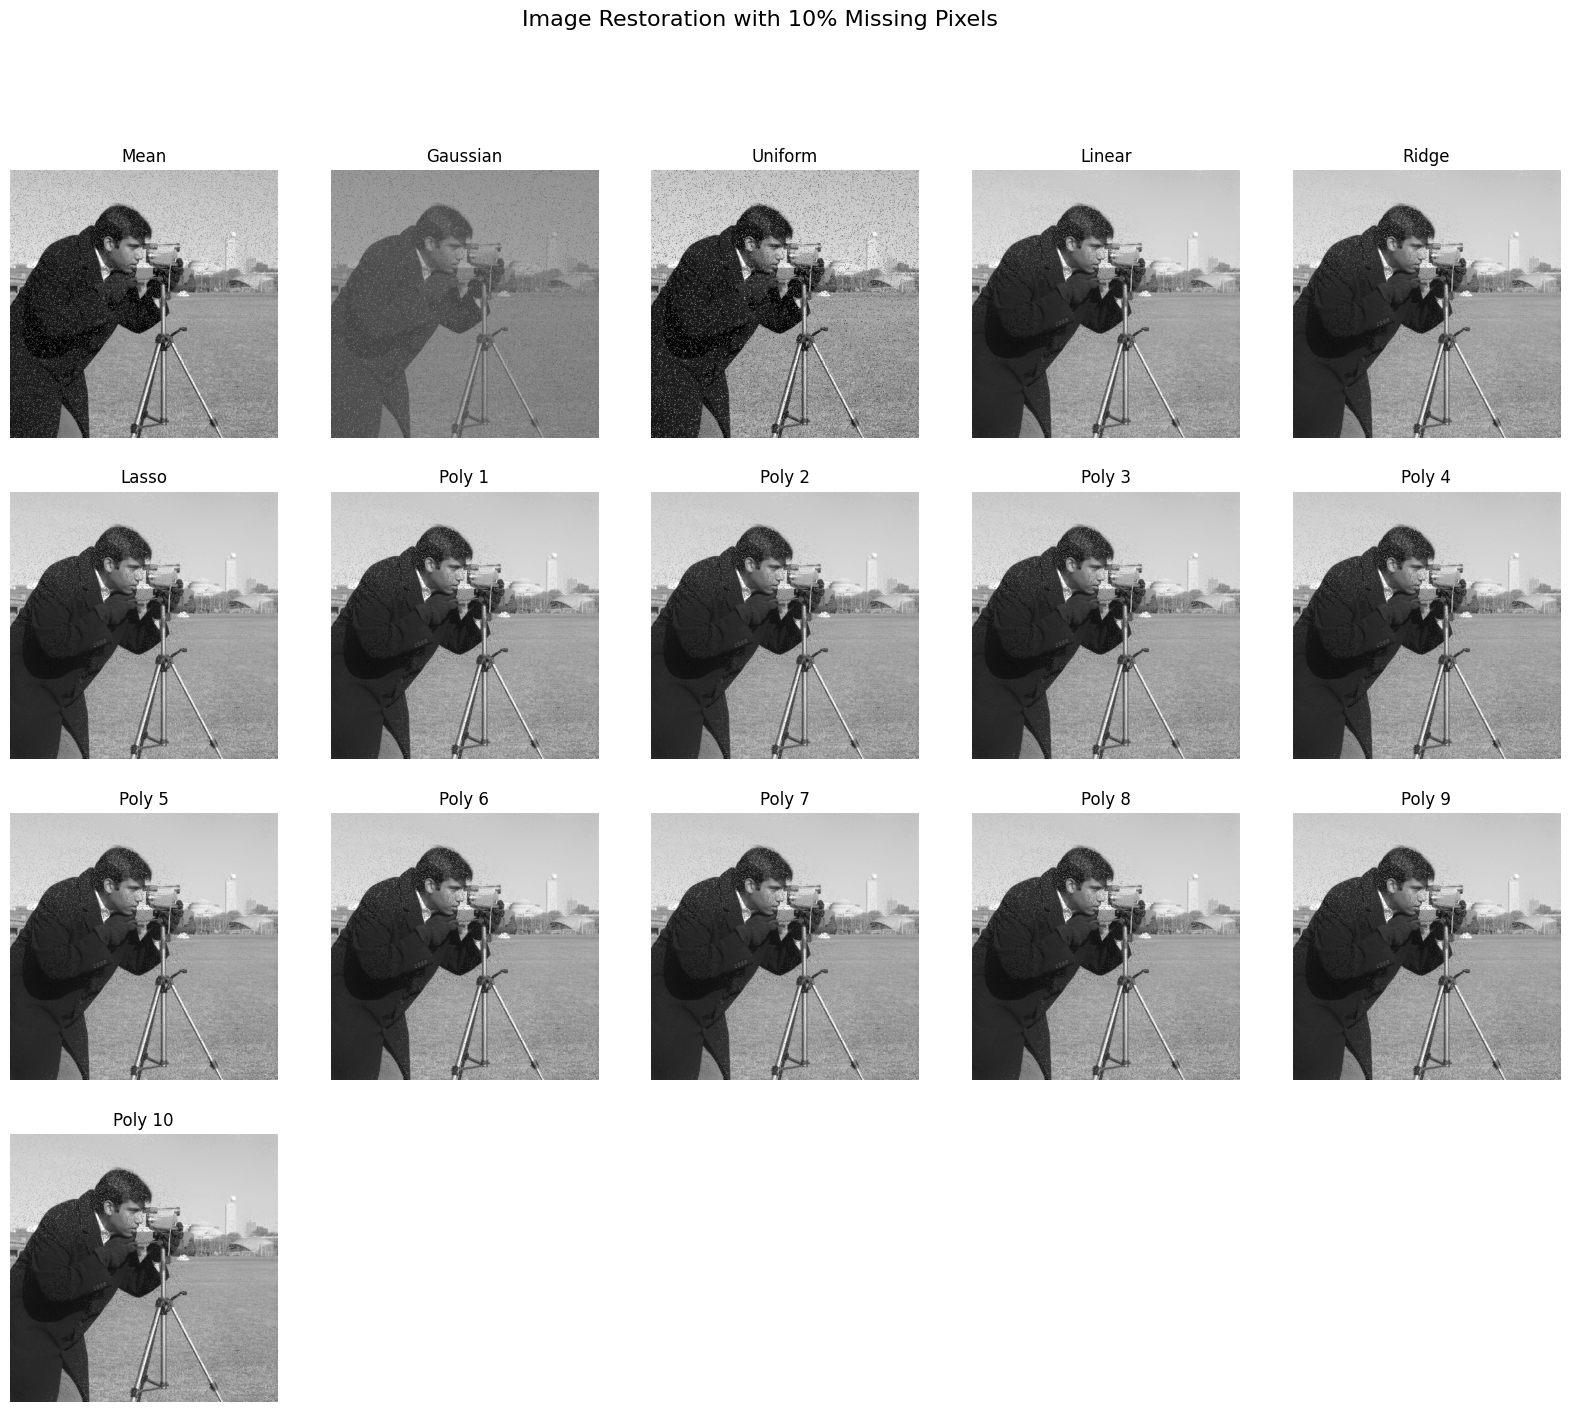

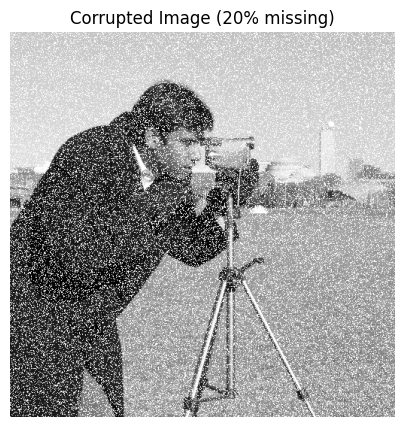

c:\Users\ROSE PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.81108e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


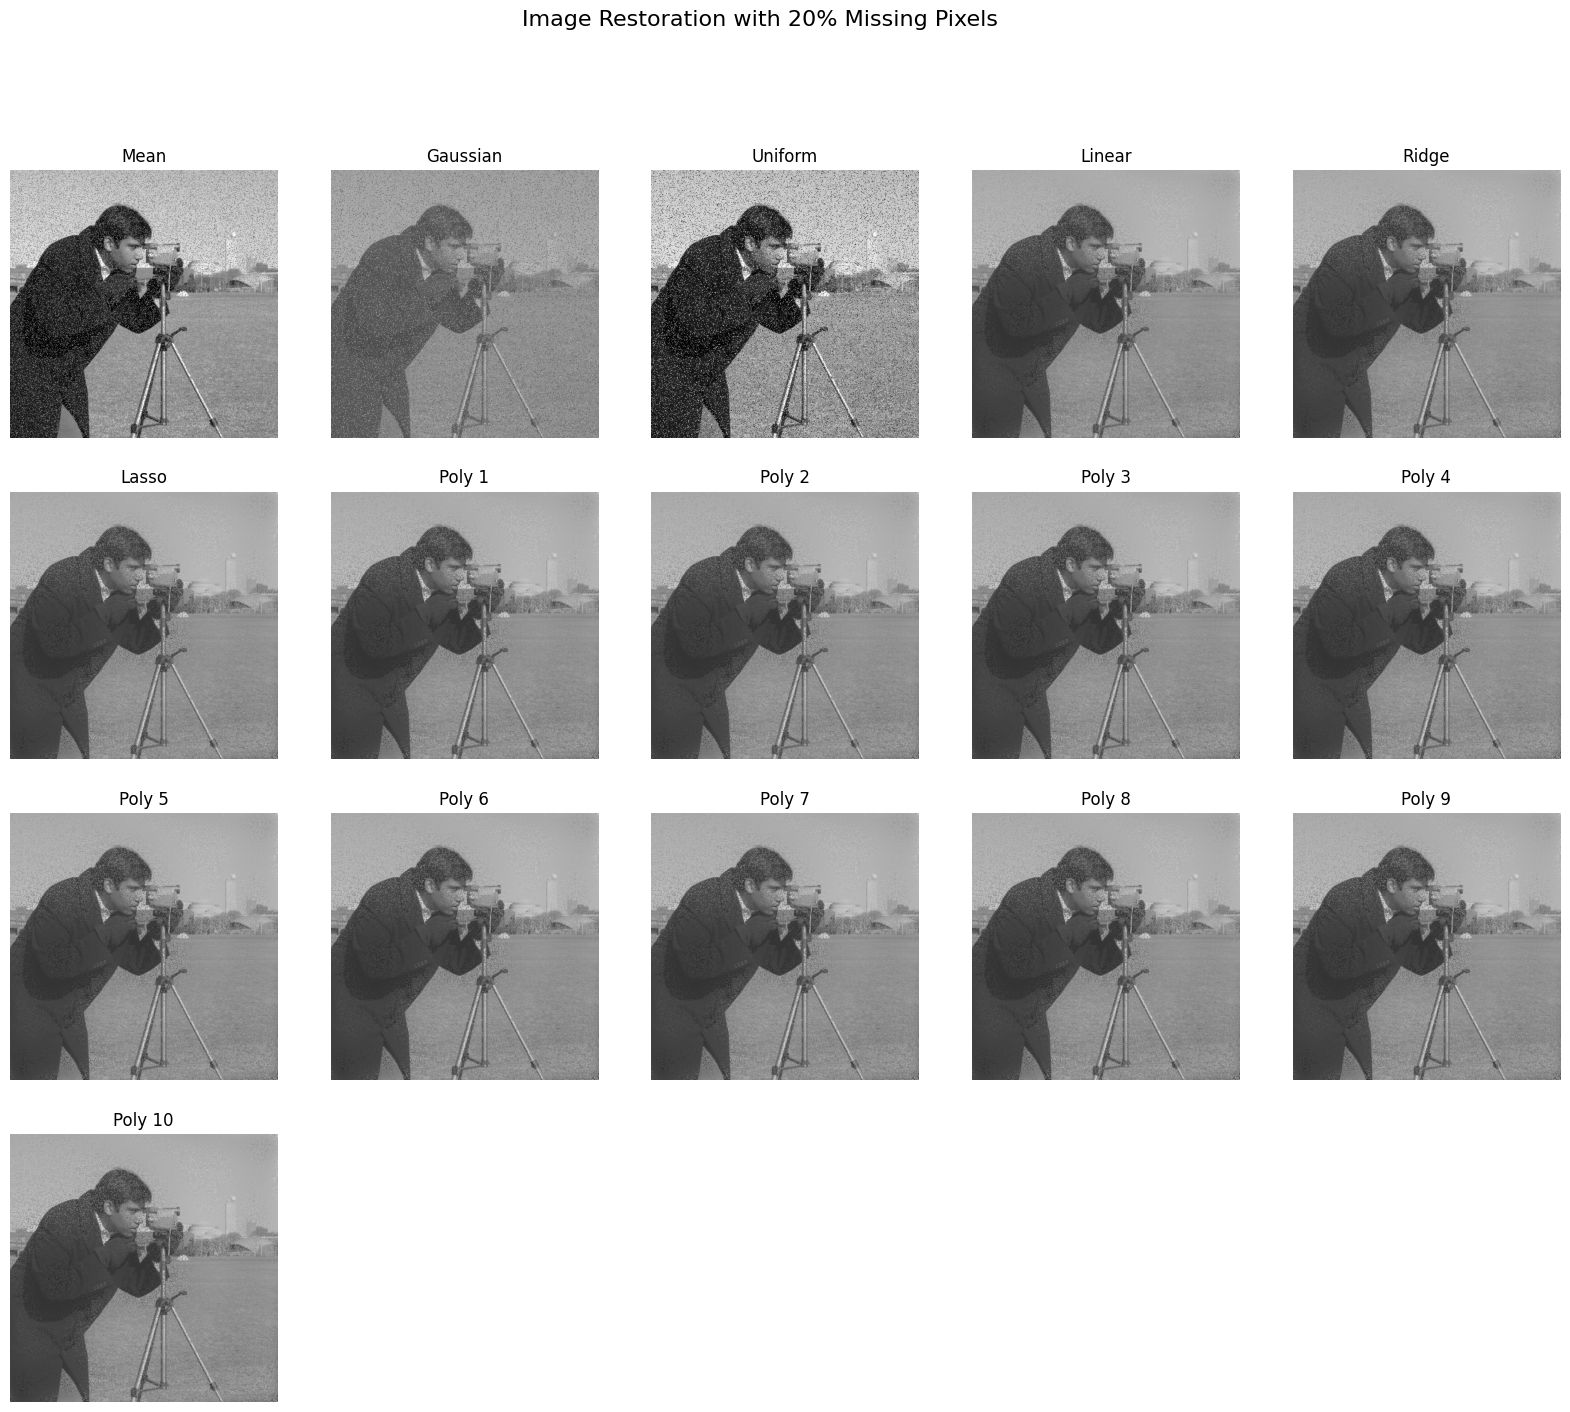

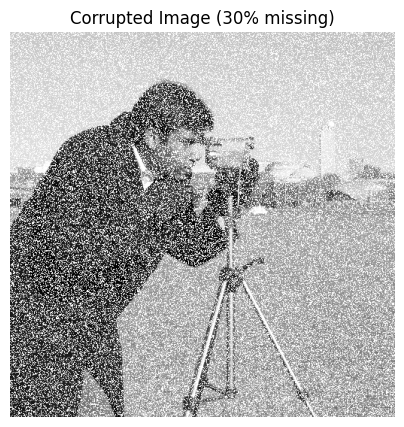

c:\Users\ROSE PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.0698e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


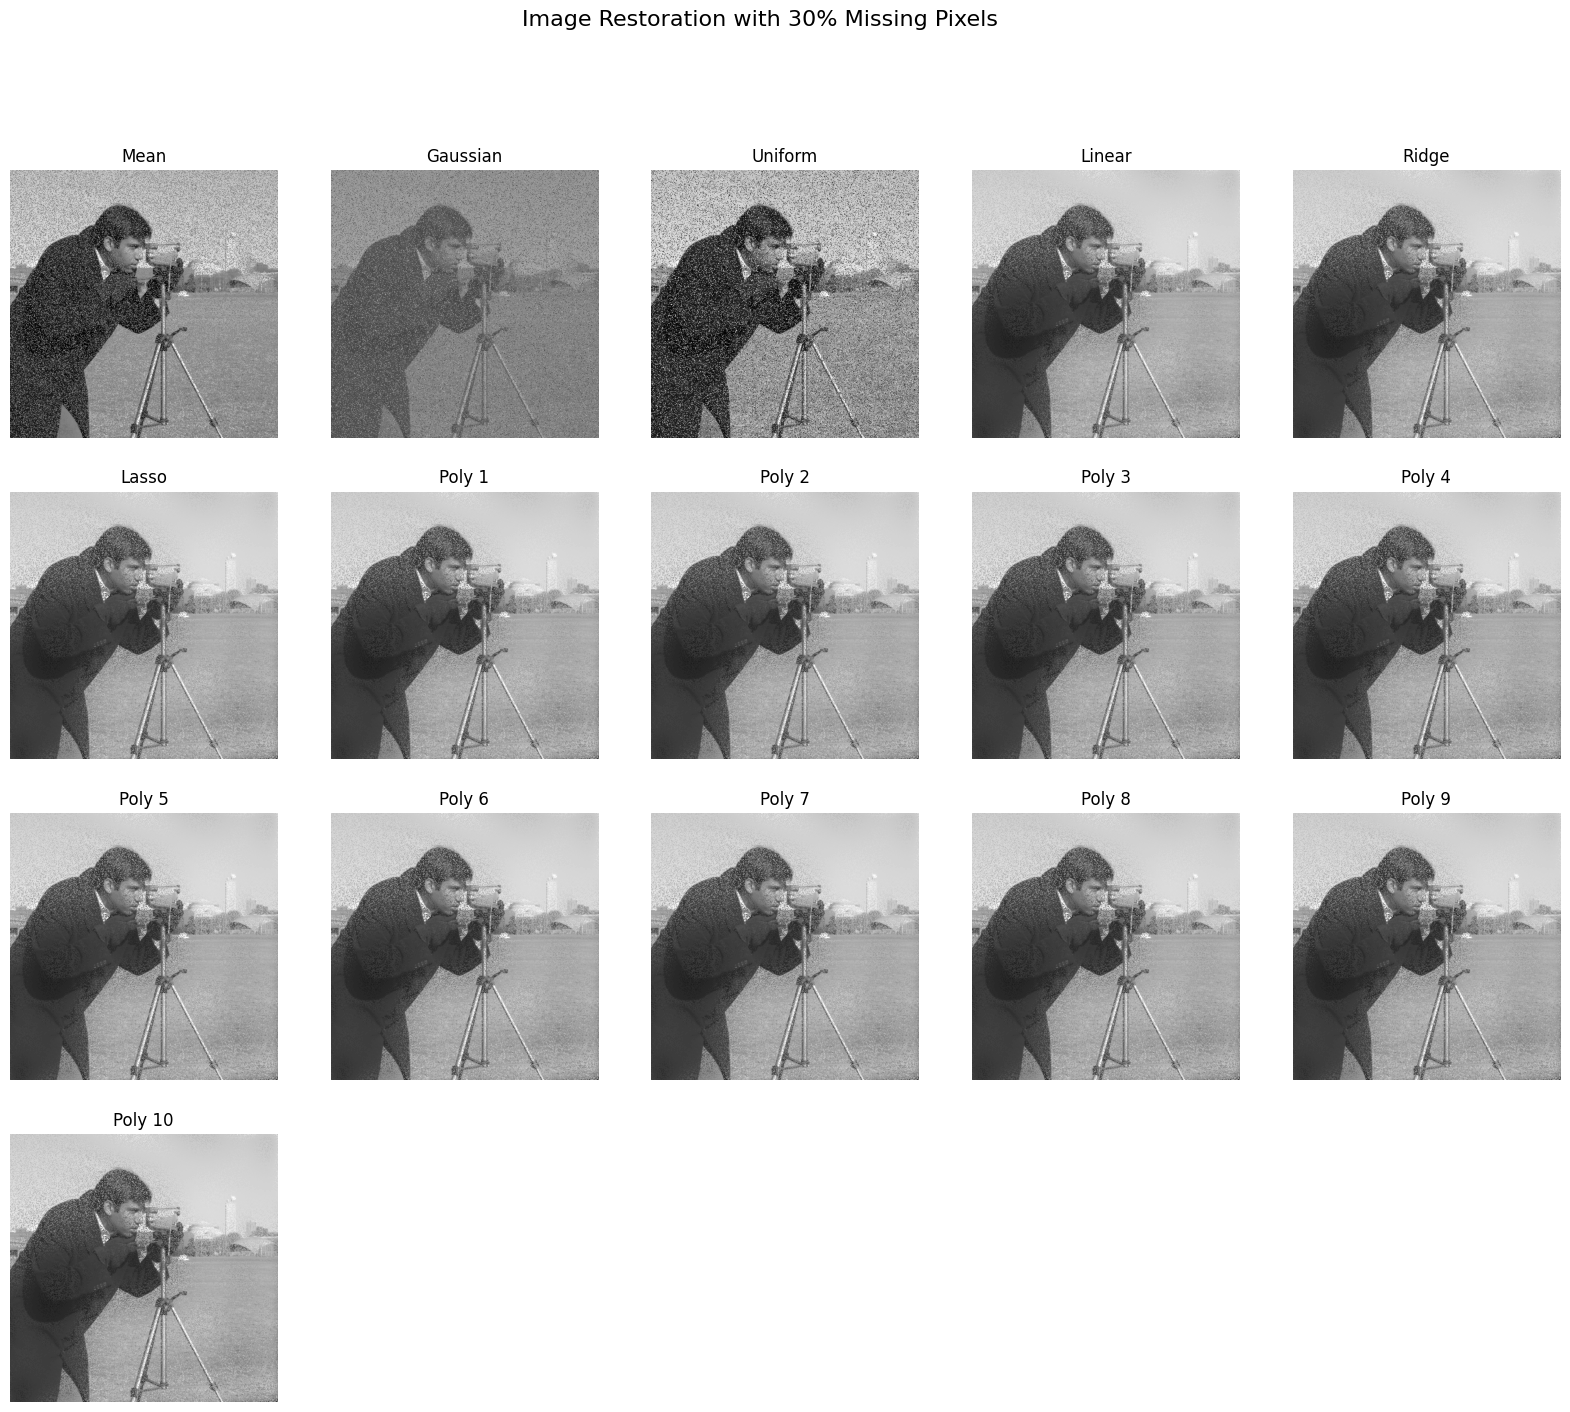

SSIM Comparison Table (Other Methods):


mean  gaussian   uniform    linear     ridge     lasso
10%  0.439786  0.296195  0.288999  0.670233  0.670233  0.670233
20%  0.352819  0.175845  0.173324  0.567924  0.567924  0.567924
30%  0.305200  0.126424  0.123380  0.504089  0.504089  0.504089

SSIM for Polynomial Degrees 1-10:


1         2         3         4         5         6         7    
10%  0.564831  0.598719  0.670478  0.708336  0.748239  0.744843  0.752468  \
20%  0.461738  0.486681  0.568208  0.608948  0.657120  0.651576  0.660083   
30%  0.403651  0.423900  0.504320  0.545246  0.596650  0.591090  0.598898   

           8         9         10  
10%  0.761886  0.760465  0.740459  
20%  0.673588  0.671244  0.576388  
30%  0.605773  0.584493  0.585505

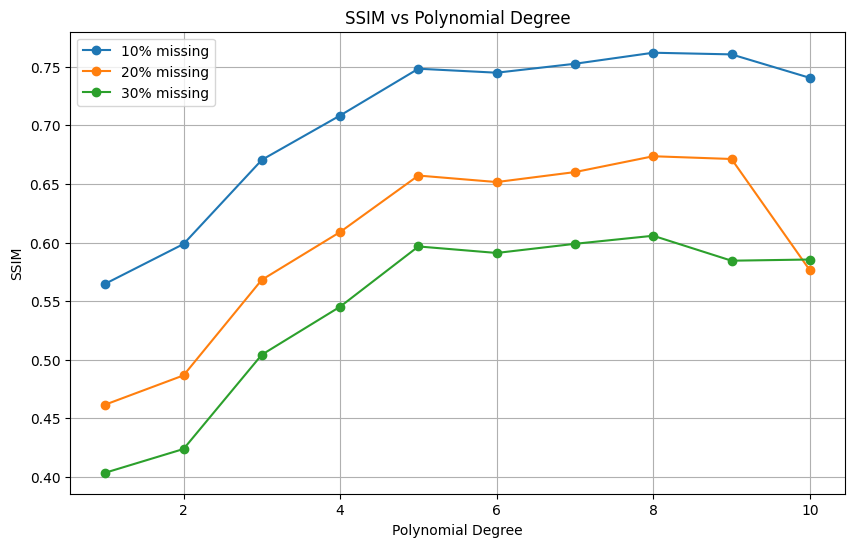

=== تحلیل نهایی ===

میزان حذف: 10%
بهترین درجه چندجمله‌ای: 8 با SSIM=0.7619
بهترین روش پایه: linear با SSIM=0.6702
مقایسه روش‌ها و درجات چندجمله‌ای:


SSIM
mean      0.439786
gaussian  0.296195
uniform   0.288999
linear    0.670233
ridge     0.670233
lasso     0.670233
Poly 1    0.564831
Poly 2    0.598719
Poly 3    0.670478
Poly 4    0.708336
Poly 5    0.748239
Poly 6    0.744843
Poly 7    0.752468
Poly 8    0.761886
Poly 9    0.760465
Poly 10   0.740459


میزان حذف: 20%
بهترین درجه چندجمله‌ای: 8 با SSIM=0.6736
بهترین روش پایه: linear با SSIM=0.5679
مقایسه روش‌ها و درجات چندجمله‌ای:


SSIM
mean      0.352819
gaussian  0.175845
uniform   0.173324
linear    0.567924
ridge     0.567924
lasso     0.567924
Poly 1    0.461738
Poly 2    0.486681
Poly 3    0.568208
Poly 4    0.608948
Poly 5    0.657120
Poly 6    0.651576
Poly 7    0.660083
Poly 8    0.673588
Poly 9    0.671244
Poly 10   0.576388


میزان حذف: 30%
بهترین درجه چندجمله‌ای: 8 با SSIM=0.6058
بهترین روش پایه: linear با SSIM=0.5041
مقایسه روش‌ها و درجات چندجمله‌ای:


SSIM
mean      0.305200
gaussian  0.126424
uniform   0.123380
linear    0.504089
ridge     0.504089
lasso     0.504089
Poly 1    0.403651
Poly 2    0.423900
Poly 3    0.504320
Poly 4    0.545246
Poly 5    0.596650
Poly 6    0.591090
Poly 7    0.598898
Poly 8    0.605773
Poly 9    0.584493
Poly 10   0.585505

In [3]:
# -----------------------------
# Import Libraries
# -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd

# -----------------------------
# 1. Load Original Image
# -----------------------------
image = img_as_float(data.camera())
plt.figure(figsize=(5,5))
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# -----------------------------
# 2. Function to Remove Pixels (Zero)
# -----------------------------
def remove_pixels(img, missing_rate):
    corrupted = img.copy()
    mask = np.random.rand(*img.shape) < missing_rate
    corrupted[mask] = 1
    return corrupted, mask

# -----------------------------
# 3. Imputation Functions
# -----------------------------
def mean_imputation(img, mask):
    mean_val = img[~mask].mean()
    imputed = img.copy()
    imputed[mask] = mean_val
    return imputed

def gaussian_noise_imputation(img, mask):
    mean_val = img[~mask].mean()
    std_val = img[~mask].std()
    noise = np.random.normal(mean_val, std_val, img.shape)
    imputed = img.copy()
    imputed[mask] = noise[mask]
    return imputed

def uniform_noise_imputation(img, mask):
    min_val = img[~mask].min()
    max_val = img[~mask].max()
    noise = np.random.uniform(min_val, max_val, img.shape)
    imputed = img.copy()
    imputed[mask] = noise[mask]
    return imputed

def regression_imputation(img, mask, degree=1, model_type='linear'):
    rows, cols = img.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    XY = np.column_stack([X.ravel(), Y.ravel()])
    Z = img.ravel()
    missing = mask.ravel()
    known = ~missing

    if known.sum() == 0:
        return img
    
    if model_type=='linear':
        model = LinearRegression()
    elif model_type=='ridge':
        model = Ridge(alpha=1.0)
    elif model_type=='lasso':
        model = Lasso(alpha=0.01, max_iter=10000)
    else:
        raise ValueError("Invalid model type")
    
    if degree > 1:
        model = make_pipeline(PolynomialFeatures(degree), model)
    
    model.fit(XY[known], Z[known])
    Z[missing] = model.predict(XY[missing])
    return Z.reshape(rows, cols)

# -----------------------------
# 4. Restore Images and Compute SSIM
# -----------------------------
missing_rates = [0.1, 0.2, 0.3]
methods = ['mean', 'gaussian', 'uniform', 'linear', 'ridge', 'lasso']
results_ssim = {m: [] for m in methods}
poly_results = {d: [] for d in range(1,11)}

for rate in missing_rates:
    corrupted, mask = remove_pixels(image, rate)
    
    # نمایش تصویر خراب شده قبل از بازسازی
    plt.figure(figsize=(5,5))
    plt.imshow(corrupted, cmap='gray')
    plt.title(f"Corrupted Image ({int(rate*100)}% missing)")
    plt.axis('off')
    plt.show()
    
    # بازسازی روش های پایه
    im_mean = mean_imputation(corrupted, mask)
    im_gauss = gaussian_noise_imputation(corrupted, mask)
    im_uniform = uniform_noise_imputation(corrupted, mask)
    im_linear = regression_imputation(corrupted, mask, degree=1, model_type='linear')
    im_ridge = regression_imputation(corrupted, mask, degree=3, model_type='ridge')
    im_lasso = regression_imputation(corrupted, mask, degree=3, model_type='lasso')
    
    base_images = [im_mean, im_gauss, im_uniform, im_linear, im_ridge, im_lasso]
    base_titles = ['Mean', 'Gaussian', 'Uniform', 'Linear', 'Ridge', 'Lasso']
    
    # محاسبه SSIM برای روش های پایه
    results_ssim['mean'].append(ssim(image, im_mean, data_range=1.0))
    results_ssim['gaussian'].append(ssim(image, im_gauss, data_range=1.0))
    results_ssim['uniform'].append(ssim(image, im_uniform, data_range=1.0))
    results_ssim['linear'].append(ssim(image, im_linear, data_range=1.0))
    results_ssim['ridge'].append(ssim(image, im_ridge, data_range=1.0))
    results_ssim['lasso'].append(ssim(image, im_lasso, data_range=1.0))
    
    # بازسازی درجات چندجمله‌ای 1 تا 10
    poly_images = []
    for d in range(1, 11):
        im_poly = regression_imputation(corrupted, mask, degree=d, model_type='linear')
        poly_results[d].append(ssim(image, im_poly, data_range=1.0))
        poly_images.append(im_poly)
    
    # نمایش همه تصاویر (روش های پایه + درجات چندجمله‌ای)
    all_images = base_images + poly_images
    all_titles = base_titles + [f'Poly {d}' for d in range(1,11)]
    
    n_cols = 5
    n_rows = int(np.ceil(len(all_images)/n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    axes = axes.ravel()
    for i, im in enumerate(all_images):
        axes[i].imshow(im, cmap='gray')
        axes[i].set_title(all_titles[i])
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f"Image Restoration with {int(rate*100)}% Missing Pixels", fontsize=16)
    plt.show()

# -----------------------------
# 5. جدول SSIM
# -----------------------------
df_ssim = pd.DataFrame(results_ssim, index=[f"{int(r*100)}%" for r in missing_rates])
print("SSIM Comparison Table (Other Methods):")
display(df_ssim)

df_poly = pd.DataFrame(poly_results, index=[f"{int(r*100)}%" for r in missing_rates])
print("SSIM for Polynomial Degrees 1-10:")
display(df_poly)

# -----------------------------
# 6. نمودار SSIM vs Polynomial Degree
# -----------------------------
plt.figure(figsize=(10,6))
for rate_idx, rate in enumerate(missing_rates):
    plt.plot(range(1,11), [poly_results[d][rate_idx] for d in range(1,11)], marker='o', label=f'{int(rate*100)}% missing')
plt.xlabel("Polynomial Degree")
plt.ylabel("SSIM")
plt.title("SSIM vs Polynomial Degree")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7. تحلیل نهایی
# -----------------------------
print("=== تحلیل نهایی ===")
for rate_idx, rate in enumerate(missing_rates):
    print(f"\nمیزان حذف: {int(rate*100)}%")
    
    # بهترین درجه چندجمله‌ای
    best_degree = max(poly_results, key=lambda d: poly_results[d][rate_idx])
    best_ssim = poly_results[best_degree][rate_idx]
    print(f"بهترین درجه چندجمله‌ای: {best_degree} با SSIM={best_ssim:.4f}")
    
    # بهترین روش پایه
    method_ssim = {m: results_ssim[m][rate_idx] for m in methods}
    best_method = max(method_ssim, key=method_ssim.get)
    print(f"بهترین روش پایه: {best_method} با SSIM={method_ssim[best_method]:.4f}")
    
    # جدول مقایسه کامل
    combined_df = pd.DataFrame({**method_ssim, **{f'Poly {d}': poly_results[d][rate_idx] for d in range(1,11)}}, index=['SSIM']).T
    print("مقایسه روش‌ها و درجات چندجمله‌ای:")
    display(combined_df)


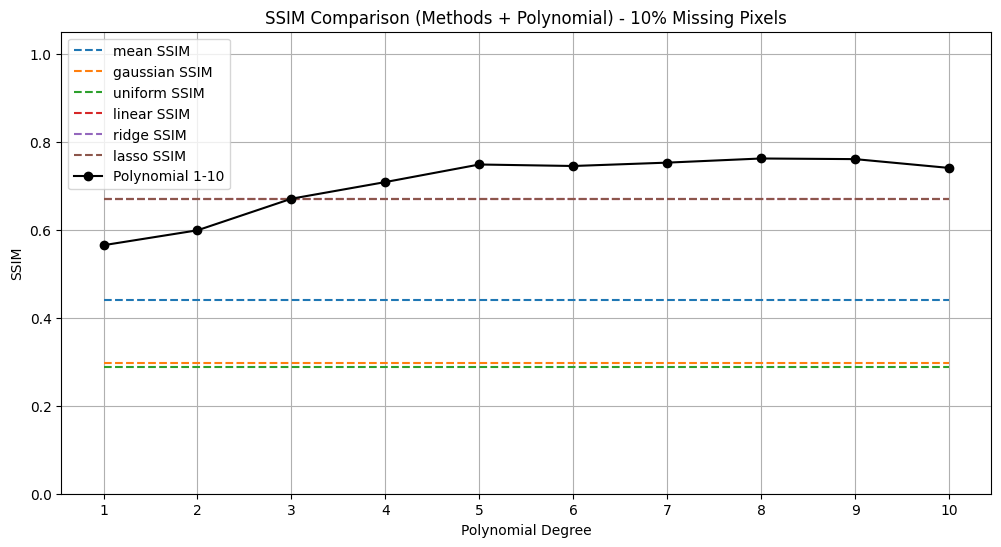

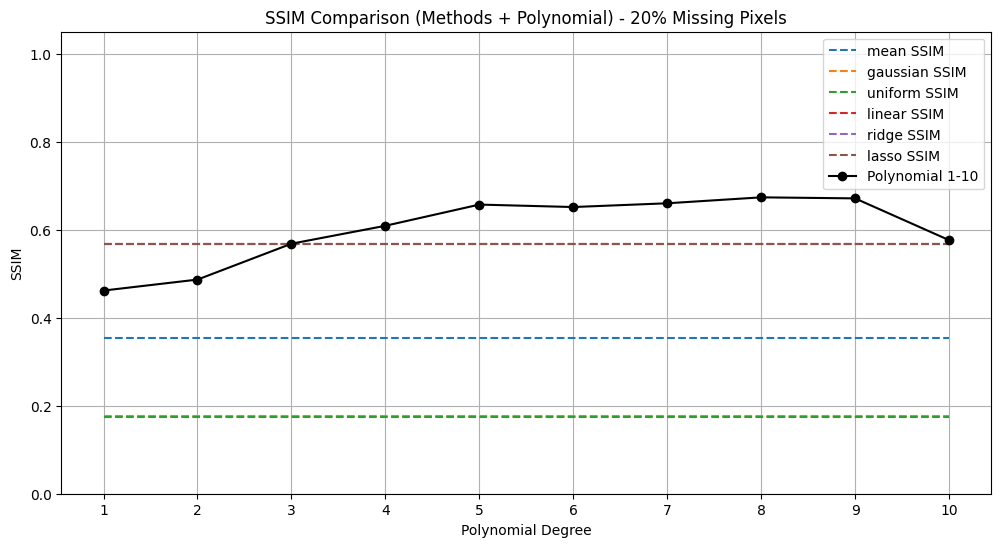

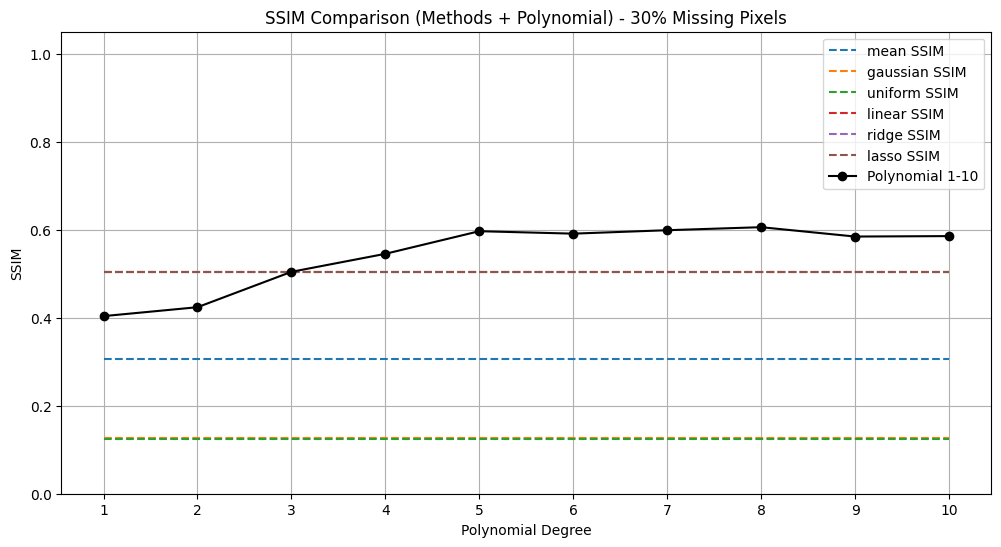

In [4]:
# -----------------------------
# 6. نمودار SSIM کامل (روش ها + Poly) برای هر درصد حذف
# -----------------------------
for rate_idx, rate in enumerate(missing_rates):
    plt.figure(figsize=(12,6))
    
    # SSIM روش‌های پایه
    for method in methods:
        plt.hlines(results_ssim[method][rate_idx], xmin=1, xmax=10, colors='C'+str(methods.index(method)), linestyles='dashed', label=f'{method} SSIM')
    
    # SSIM درجات چندجمله‌ای
    plt.plot(range(1,11), [poly_results[d][rate_idx] for d in range(1,11)], marker='o', color='black', label='Polynomial 1-10')
    
    plt.xlabel("Polynomial Degree")
    plt.ylabel("SSIM")
    plt.title(f"SSIM Comparison (Methods + Polynomial) - {int(rate*100)}% Missing Pixels")
    plt.xticks(range(1,11))
    plt.ylim(0,1.05)
    plt.grid(True)
    plt.legend()
    plt.show()
